In [1]:
# common imports
import numpy as np
import os
import sklearn
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost
from xgboost import XGBRFClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


# to make this notebook's output stable across runs
np.random.seed(4)

# to plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
pipeline = pickle.load(open('../model/best_ensemble_model','rb'))

model = pipeline[1]

train = pd.read_csv('../data/train_newfeats_drop.csv')

In [4]:
X = train.drop(['Cover_Type'], axis= 1)
y = train['Cover_Type']

transformer = QuantileTransformer()

trans_X = transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model.fit(X_train, y_train)

y_test_pred_model = model.predict(X_test)

print (model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.8898809523809523


In [9]:
print(classification_report(y_test, y_test_pred_model))

              precision    recall  f1-score   support

           1       0.81      0.80      0.80       421
           2       0.81      0.72      0.76       438
           3       0.89      0.87      0.88       428
           4       0.94      0.99      0.97       449
           5       0.91      0.96      0.94       416
           6       0.88      0.91      0.89       432
           7       0.96      0.99      0.97       440

    accuracy                           0.89      3024
   macro avg       0.89      0.89      0.89      3024
weighted avg       0.89      0.89      0.89      3024



In [10]:
print(accuracy_score(y_test, y_test_pred_model))
print(precision_score(y_test, y_test_pred_model, average='macro'))
print(recall_score(y_test, y_test_pred_model, average='macro'))
print(f1_score(y_test, y_test_pred_model, average='macro'))

0.8898809523809523
0.8871867375802119
0.8894256219098847
0.8877289094737442


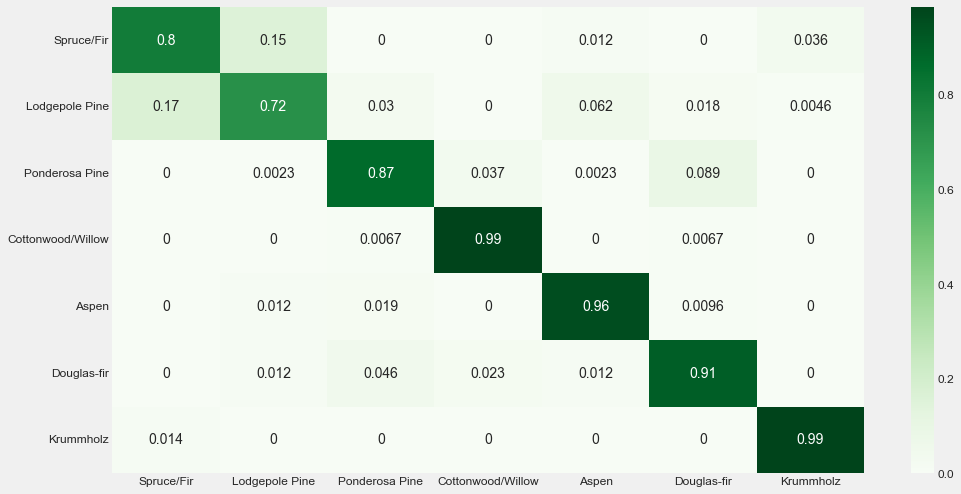

In [11]:
x_axis_labels = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz'] 
y_axis_labels = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz'] 

plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_test_pred_model, normalize='true'), annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='Greens');

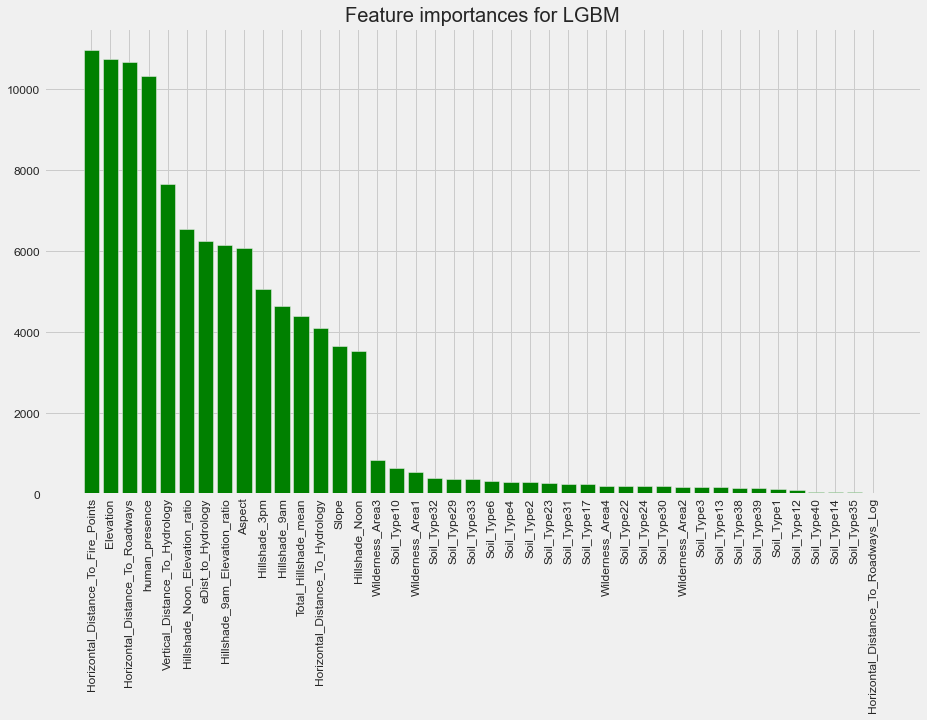

In [15]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (14,8))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#008000')
plt.title('Feature importances for LGBM', size=20)
plt.xticks(rotation='vertical')
plt.show()

## otra idea: 

no agrupamos, como antes, las categorías que más se confunden entre sí; ahora, separamos los valores del target que epresentan zonas de vegetación en el primer modelo, y los valores de traget que se refieren a especies de árboles por otro.

In [8]:
train__1 = train[(train['Cover_Type'].isin([1,7]))]
train__2 = train[(train['Cover_Type'].isin([2,3,4,5,6]))]

## modelo 1

In [9]:
# initialize the classificators
rfc= RandomForestClassifier(random_state=77)
etc = ExtraTreesClassifier(random_state=77)
lgbm = lgb.LGBMClassifier(objective= 'binary',random_state=77)

# now, create a list with the objects 
models= [rfc, etc, lgbm]

In [10]:
X_1= train__1.drop(['Cover_Type'], axis=1) 
y_1= train__1['Cover_Type']
X_1_train, X_1_test, y_1_train, y_1_test= train_test_split(X_1,y_1, test_size= 0.2)

In [11]:
for model in models:
    model.fit(X_1_train, y_1_train) 
    train_score= model.score(X_1_train, y_1_train) 
    test_score= model.score(X_1_test, y_1_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.93


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.95


The score in train of model LGBMClassifier is 1.00
The score in test of model LGBMClassifier is 0.95




In [12]:
y_1_test_pred_etc = etc.predict(X_1_test)

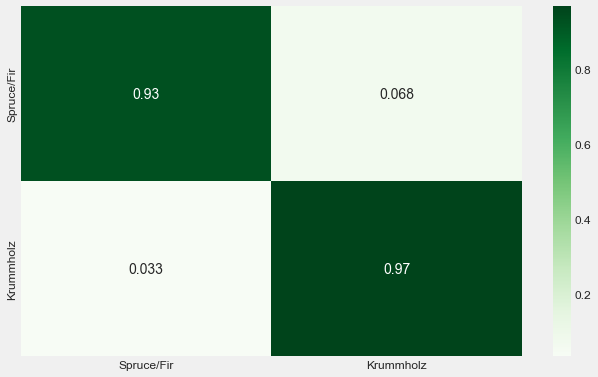

In [13]:
x_axis_labels = ['Spruce/Fir','Krummholz'] 
y_axis_labels = ['Spruce/Fir','Krummholz'] 

plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_1_test, y_1_test_pred_etc, normalize='true'), annot=True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap='Greens');

In [16]:
# import pickle
# from datetime import datetime

# filename = 'model_1'

# #path = '../model/model_1'

# with open(filename, 'wb') as archivo_salida:
#     pickle.dump(etc, archivo_salida)

In [17]:
importances = pd.DataFrame(data={
    'Attribute': X_1.columns,
    'Importance': etc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

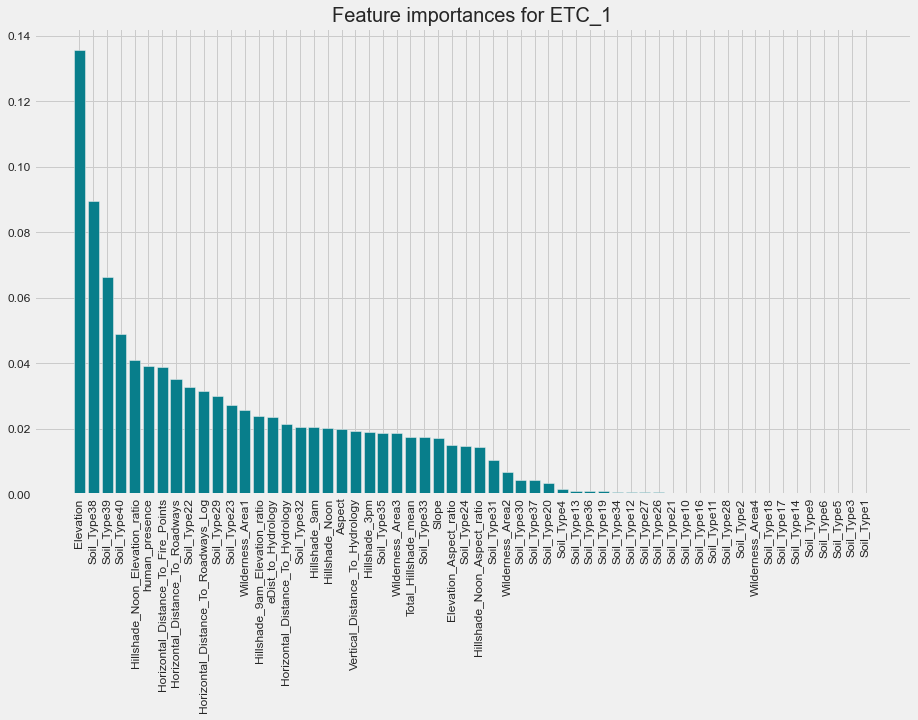

In [18]:
plt.figure(figsize = (14,8))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#008000')
plt.title('Feature importances for ETC_1', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [19]:
# initialize the classificators
rfc_2= RandomForestClassifier(random_state=77)
etc_2 = ExtraTreesClassifier(random_state=77)
lgbm_2 = lgb.LGBMClassifier(random_state=77)

# now, create a list with the objects 
models= [rfc_2, etc_2, lgbm_2]

In [20]:
X_2= train__2.drop(['Cover_Type'], axis=1) 
y_2= train__2['Cover_Type']
X_2_train, X_2_test, y_2_train, y_2_test= train_test_split(X_2,y_2, test_size= 0.2)

In [21]:
for model in models:
    model.fit(X_2_train, y_2_train) 
    train_score= model.score(X_2_train, y_2_train) 
    test_score= model.score(X_2_test, y_2_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.88


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.89


The score in train of model LGBMClassifier is 1.00
The score in test of model LGBMClassifier is 0.90




In [27]:
y_1_test_pred_etc_2 = lgbm_2.predict(X_2_test)

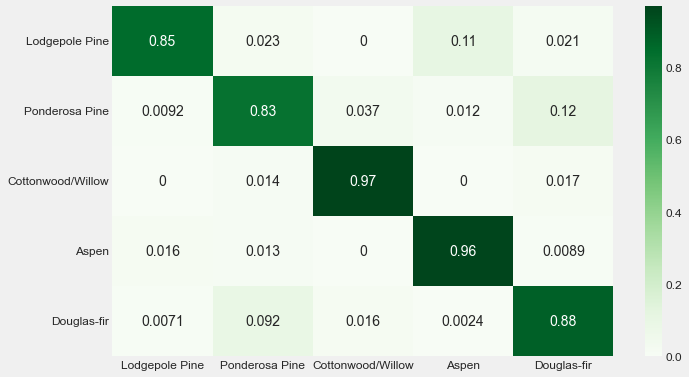

In [28]:
x_axis_labels = ['Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir'] 
y_axis_labels = ['Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir'] 

plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_2_test, y_1_test_pred_etc_2, normalize='true'), annot=True, 
                            xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='Greens');

In [29]:
importances = pd.DataFrame(data={
    'Attribute': X_1.columns,
    'Importance': etc_2.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

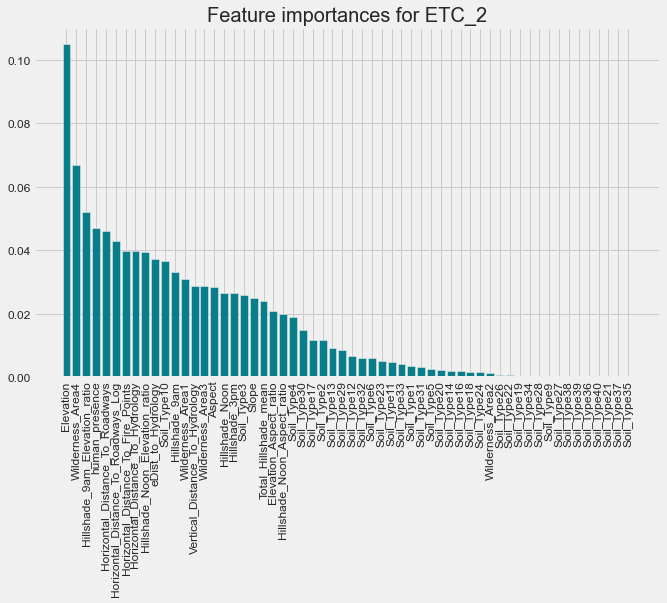

In [30]:
plt.figure(figsize = (10,6))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#008000')
plt.title('Feature importances for ETC_2', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [31]:
# import pickle
# from datetime import datetime

# filename = 'model_2'


# with open(filename, 'wb') as archivo_salida:
#     pickle.dump(etc_2, archivo_salida)